In [15]:
import sys
import os
from pathlib import Path

# importディレクトリの追加
# sys.path.append(os.path.join(os.path.dirname(__file__), '..'))
print(sys.path)

# プロキシの設定
# os.environ['HTTP_PROXY'] = ''
# os.environ['HTTPS_PROXY'] = ''

%matplotlib inline

['/home/y-katayama/notebooks/dl_study/02_pytorch_tutorial', '/usr/lib/python38.zip', '/usr/lib/python3.8', '/usr/lib/python3.8/lib-dynload', '', '/home/y-katayama/venv/pt1.7/lib/python3.8/site-packages']


In [16]:
import onnx
import onnxruntime

In [17]:
import io
import numpy as np

from torch import nn
import torch.utils.model_zoo as model_zoo
import torch.onnx

- PyTorchでSuperResolutionモデルを構築する  
    - ref. https://arxiv.org/abs/1609.05158

In [18]:
import torch.nn as nn
import torch.nn.init as init

class SuperResolutionNet(nn.Module):
    def __init__(self, upsclale_factor, inplace=False) -> None:
        super(SuperResolutionNet, self).__init__()

        self.relu = nn.ReLU(inplace=inplace)
        self.conv1 = nn.Conv2d(1, 64, (5, 5), (1, 1), (2, 2))
        self.conv2 = nn.Conv2d(64, 64, (3, 3), (1, 1), (1, 1))
        self.conv3 = nn.Conv2d(64, 32, (3, 3), (1, 1), (1, 1))
        self.conv4 = nn.Conv2d(32, upsclale_factor ** 2, (3, 3), (1, 1), (1, 1))
        self.pixel_shuffle= nn.PixelShuffle(upsclale_factor)

        self._initialize_weights()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.pixel_shuffle(self.conv4(x))
        return x

    def _initialize_weights(self):
        init.orthogonal_(self.conv1.weight, init.calculate_gain('relu'))
        init.orthogonal_(self.conv2.weight, init.calculate_gain('relu'))
        init.orthogonal_(self.conv3.weight, init.calculate_gain('relu'))
        init.orthogonal_(self.conv4.weight)

torch_model = SuperResolutionNet(upsclale_factor=3)

In [20]:
model_url = 'https://s3.amazonaws.com/pytorch/test_data/export/superres_epoch100-44c6958e.pth'
batch_size = 1

# initialize model with pretrained weights
map_location = lambda storage, loc: storage
if torch.cuda.is_available():
    map_location = None

torch_model.load_state_dict(model_zoo.load_url(model_url, map_location=map_location))

torch_model.eval()

SuperResolutionNet(
  (relu): ReLU()
  (conv1): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(32, 9, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pixel_shuffle): PixelShuffle(upscale_factor=3)
)

## ONNXへの変換と実行

- pytorchでモデルをエクスポートするには 二つの方式がある(?)
    - `trace` or `script`
- このチュートリアルでは, `trace`によるエクスポート方法を学ぶ

- モデルのエクスポートには`torch.onnx.export()`を使用する
- export()はモデルを実行するので, ダミーとなる入力テンソルを与える必要がある

- エクスポートされるONNXグラフの入力サイズは固定となる
    - 動的軸(dynamic_axes)として指定されている場合はこの限りではない

- このチュートリアルでは, バッチサイズにあたる最初の次元のみ`dynamic_axes`として扱う
- したがって, エクスポートされたモデルは, `[batch_size, 1, 224, 224]`の入力を想定することになる

PyTorchのエクスポート方法の詳細は, [torch.onnxドキュメント](https://pytorch.org/docs/master/onnx.html)を参照のこと

In [21]:
x = torch.randn(batch_size, 1, 224, 224, requires_grad=True)
torch_out = torch_model(x)

torch.onnx.export(torch_model,               # 対象モデル
                  x,                         # 入力サンプル
                  "super_resolution.onnx",   # 保存先
                  export_params=True,        # モデルファイルに訓練した重みを保存するかどうか
                  opset_version=10,          # ONNXのバージョン
                  do_constant_folding=True,  # constant folding for optimizationを実施するかどうか
                  input_names = ['input'],   # モデルへの入力変数名
                  output_names = ['output'], # モデルの出力変数名
                  dynamic_axes={'input' : {0 : 'batch_size'},    # 動的軸（dynamic axes）の指定
                                'output' : {0 : 'batch_size'}})

## ONNXモデルのロードと検証

- `onnx.load`は保存されたモデルを読み込み, onnx.ModelProto構造体を出力する
    - onnx.ModelProtoはMLモデルを束ねるための最上位のコンテナフォーマット
    - 詳細は[onnx.protoドキュメント](https://github.com/onnx/onnx/blob/master/onnx/onnx.proto)を参照

- `onnx.checker.check_model()`はモデルの構造をチェックし, 定められたスキームの準拠しているか確かめる

- ONNXグラフの妥当性はモデルのバージョン, グラフの構造, ノードとその入出力を確認して検証される

In [22]:
onnx_model = onnx.load('super_resolution.onnx')
onnx.checker.check_model(onnx_model)


## ONNX Runtimeでのモデルの推論

- `onnxruntime.InferenceSession()`を用いる

- sessionは明示的に使用しない限り, ファイル名に応じて, 自動的に推測される
    - 明示的に指定する場合は`sess_options`にオプションを指定できる
    - https://onnxruntime.ai/docs/api/python/api_summary.html#id10


- 詳細は以下のドキュメントを参照
    - https://onnxruntime.ai/docs/api/python/api_summary.html

In [24]:
import onnxruntime

# 推論セッションを作成
ort_session = onnxruntime.InferenceSession('super_resolution.onnx')

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# ONNX Runtimeで推論
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(x)}
ort_outs = ort_session.run(None, ort_inputs)

# ONNX RuntimeとPyTorchの結果を比較
np.testing.assert_allclose(to_numpy(torch_out), ort_outs[0], rtol=1e-03, atol=1e-05)

print("Exported model has been tested with ONNXRuntime, and the result looks good!")
print(to_numpy(torch_out))
print(ort_outs[0])

Exported model has been tested with ONNXRuntime, and the result looks good!
[[[[-0.0976152  -0.03036087  0.2688146  ...  0.09128544  0.21321757
     0.12018898]
   [-0.19890659 -0.10203859  0.2754036  ...  0.19738117  0.26139626
     0.13834466]
   [-0.00530529  0.1429033   0.37752515 ...  0.19213429  0.09401494
    -0.06593699]
   ...
   [ 0.44347885  0.47966045  0.4917076  ...  0.82145655  0.9042088
     0.76055807]
   [ 0.48685512  0.53381413  0.46811745 ...  0.6295125   0.7233696
     0.73042405]
   [ 0.44502112  0.39965037  0.30125847 ...  0.3628418   0.5680377
     0.66969156]]]]
[[[[-0.09761525 -0.03036096  0.26881462 ...  0.0912855   0.21321757
     0.120189  ]
   [-0.1989066  -0.10203867  0.27540356 ...  0.1973812   0.26139635
     0.13834465]
   [-0.00530536  0.14290327  0.3775251  ...  0.19213429  0.09401491
    -0.06593698]
   ...
   [ 0.4434787   0.47966033  0.49170753 ...  0.82145673  0.9042086
     0.7605577 ]
   [ 0.4868548   0.533814    0.46811712 ...  0.62951267  0.72

## ONNX Runtimeでの画像入力

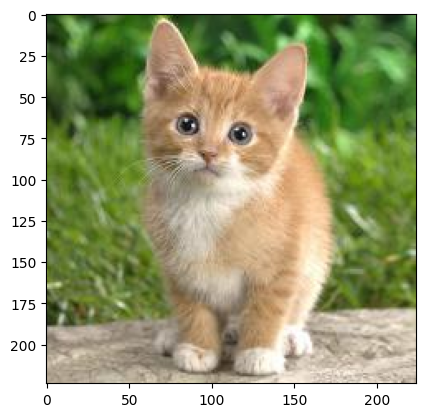

In [25]:
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

img = Image.open('./data/cat_224x224.jpg')
plt.imshow(img)
plt.show()

- モデルの入力サイズに合わせる
  1. 入力画像をリサイズして
  2. YCbCrの各成分に分割する
  3. Y成分のみを抽出してテンソルに変換する

- 後処理の手順は下記を参照
  - https://github.com/pytorch/examples/blob/master/super_resolution/super_resolve.py



In [26]:
import torchvision.transforms as transforms

# リサイズインスタンスを定義
resize = transforms.Resize([224, 224])
img = resize(img)

img_ycbcr = img.convert('YCbCr')
img_y, img_cb, img_cr = img_ycbcr.split()

# テンソル変換インスタンスを定義
to_tensor = transforms.ToTensor()
img_y = to_tensor(img_y)
img_y.unsqueeze_(0)

tensor([[[[0.2157, 0.1961, 0.1922,  ..., 0.5294, 0.5569, 0.5686],
          [0.2039, 0.1961, 0.1922,  ..., 0.5333, 0.5569, 0.5686],
          [0.1961, 0.1843, 0.1843,  ..., 0.5216, 0.5412, 0.5490],
          ...,
          [0.6667, 0.6745, 0.6392,  ..., 0.6902, 0.6667, 0.6078],
          [0.6392, 0.6431, 0.6235,  ..., 0.8000, 0.7608, 0.6745],
          [0.6392, 0.6353, 0.6510,  ..., 0.8118, 0.7686, 0.6667]]]])

In [30]:
img_out_y.shape

(1, 1, 672, 672)

- `get_inputs()`, `get_outputs()`を利用して, ONNXモデルに割り当てられた出力に対応するOrtValueにアクセスできる

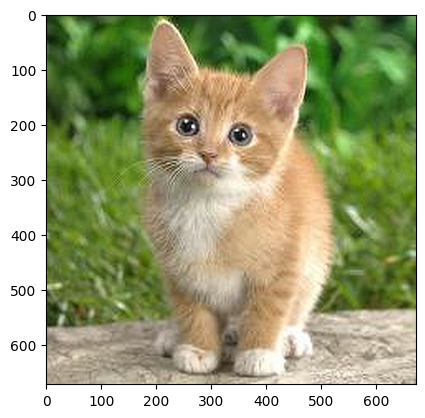

In [33]:
# ONNX Runtimeで推論処理を行う
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(img_y)}
ort_outs = ort_session.run(None, ort_inputs)
img_out_y = ort_outs[0]

img_out_y = Image.fromarray(np.uint8((img_out_y[0] * 255.0).clip(0, 255)[0]), mode='L')

# モデルの出力を可視化する
final_img = Image.merge(
    'YCbCr', [
        img_out_y,
        img_cb.resize(img_out_y.size, Image.BICUBIC),
        img_cr.resize(img_out_y.size, Image.BICUBIC),
    ]).convert('RGB')

plt.imshow(final_img)
plt.show()

ONNXランタイムはクロスプラットフォームエンジンであるため、複数のプラットフォームにまたがって、CPUとGPUの両方で実行することができます。

<br>

またONNXランタイムは、Azure Machine Learning Servicesのモデル推論用に、クラウドにデプロイすることも可能です。

Azure MLサービスの詳細はについては、[こちら](https://docs.microsoft.com/en-us/azure/machine-learning/service/concept-onnx)をご覧ください。


ONNX Runtimeのパフォーマンス情報については、[こちら](https://github.com/microsoft/onnxruntime#high-performance)をご覧ください。

また、その他、ONNX Runtimeについての詳細情報は、[こちら](https://github.com/microsoft/onnxruntime)をご覧ください。


